# MLNS Final Project: Into the Networks of Life
------------------------------------------------------------
### Authors: Dwivedi Deepesh, Giacopelli Nicolò, Liu Dayu, Remadi Adel

# Graph Classification - ENZYMES

Installing the required DGL library to use the TUDataSet of ENZYMES

In [ ]:
! pip install dgl --quiet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 47.8 MB/s eta 0:00:00


In [ ]:
# Import packages
import dgl
import torch
import torch.nn.functional as F
import numpy as np
from dgl.dataloading import GraphDataLoader
from dgl.nn import GraphConv
from IPython.display import Latex
from sklearn.model_selection import train_test_split

In [ ]:
'''
Creating the self loops for the nodes where it is present, the difference between the PyTorch and DGL library datasets is the self node loops primarily
'''
dataset_enzymes = dgl.data.TUDataset(name='ENZYMES')

# Add self loop to each graph
dataset_enzymes.graph_lists = [dgl.add_self_loop(graph) for graph in dataset_enzymes.graph_lists]

In [ ]:
dataset_enzymes[0]

(Graph(num_nodes=37, num_edges=205,
       ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'node_attr': Scheme(shape=(18,), dtype=torch.float64), 'node_labels': Scheme(shape=(1,), dtype=torch.int64)}
       edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)}),
 tensor([5]))

In [ ]:
print('Number of graph categories:', dataset_enzymes.num_labels)
print('Dimension of nodes features', dataset_enzymes[0][0].ndata['node_attr'].shape[1])

Number of graph categories: 6
Dimension of nodes features 18


In [ ]:
# Split dataset into train, validation and test sets
train_sampler, val_sampler, test_sampler = dgl.data.utils.split_dataset(
        dataset_enzymes, frac_list=[0.6, 0.2, 0.2], shuffle=True)

In [ ]:
# batch graphs with GraphDataLoader
train_dataloader = GraphDataLoader(
        train_sampler, batch_size=5, drop_last=False)
val_dataloader = GraphDataLoader(
    val_sampler, batch_size=5, drop_last=False)
test_dataloader = GraphDataLoader(
    test_sampler, batch_size=5, drop_last=False)

In [ ]:
'''
  Here this is the basic graph model which we created based in the Graph Convolutional Layers. Here we created a for loop so that
  we can easily manipulate the number of layers and do hyperparameter tuning. We received the best accuracy with 3 layers and hidden size as 128
'''
class BasicGraphModel(torch.nn.Module):

    def __init__(self, n_layers, input_size, hidden_size, output_size):
        super(BasicGraphModel, self).__init__()

        # Define GNN components
        self.convs = torch.nn.ModuleList()
        self.convs.append(GraphConv(input_size, hidden_size))
        for i in range(n_layers-1):
            self.convs.append(GraphConv(hidden_size, hidden_size))
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, g, x):
        # Message Passing -- Learn node representations via GCN
        for conv in self.convs[:-1]:
            x = conv(g, x)
            x = F.leaky_relu(x)
        x = self.convs[-1](g, x)
        # Readout -- average all node representations to get graph embedding
        g.ndata['h'] = x
        x = dgl.mean_nodes(g, 'h')
        # Apply linear layer to classify graph representation
        x = self.linear(x)
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl.nn import GATConv
'''
  Here we are using GAT , which obviously uses Attention mechanism. Since enzyme also resemble to a sequence , having an attention mechanism
  definitely helps with the accuracy. This model is also created in an easy to use customisable way to do hyperparameter tuning of 
  layers.

'''


class GATModel(nn.Module):
    def __init__(self, n_layers, input_size, hidden_size, output_size, n_heads):
        super(GATModel, self).__init__()

        # Define GNN components
        self.convs = nn.ModuleList()
        self.convs.append(GATConv(input_size, hidden_size, num_heads=n_heads))
        for i in range(n_layers - 1):
            self.convs.append(GATConv(hidden_size * n_heads, hidden_size, num_heads=n_heads))
        self.linear = nn.Linear(hidden_size * n_heads, output_size)

    def forward(self, g, x):
        # Message Passing -- Learn node representations via GAT
        for conv in self.convs[:-1]:
            x = conv(g, x)
            x = F.elu(x)
            x = x.view(x.shape[0], -1)  # Flatten the output for the next layer
        x = self.convs[-1](g, x)
        x = x.view(x.shape[0], -1)  # Flatten the output before readout
        
        # Readout -- average all node representations to get graph embedding
        g.ndata['h'] = x
        x = dgl.mean_nodes(g, 'h')
        
        # Apply linear layer to classify graph representation
        x = self.linear(x)
        return x


In [ ]:
#this is the training funciton
def train(model, loss_fcn, optimizer, train_dataloader, val_dataloader, num_epochs):
    model = model.double()
    model.train()

    for epoch in range(num_epochs):
        losses = []
        for batch, batched_graph in enumerate(train_dataloader):
            batched_graph, labels = batched_graph
            logits = model(batched_graph, batched_graph.ndata['node_attr'].double())
            loss = loss_fcn(logits, labels.T[0])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.mean(losses)

        if epoch % 5 == 0:
            print("Epoch {} | Loss: {:.4f}".format(epoch, loss_data))
            test(model, loss_fcn, val_dataloader)



In [ ]:
#test function
def test(model, loss_fcn, dataloader):
    scores = []
    for batch, batched_graph in enumerate(dataloader):
        batched_graph, labels = batched_graph
        scores.append(
            evaluate(model, batched_graph, labels, loss_fcn))
    mean_scores = np.mean(scores)
    print("Accuracy score: {:.4f}".format(mean_scores))
    


' \ndef test(model, loss_fcn, dataloader):\n    scores = []\n    for batch, batched_graph in enumerate(dataloader):\n        batched_graph, labels = batched_graph\n        scores.append(\n            evaluate(model, batched_graph, labels, loss_fcn))\n    mean_scores = np.mean(scores)\n    return mean_scores\n'

In [ ]:
def evaluate(model, batched_graph, labels, loss_fcn):
    model = model.double()
    model.eval()
    with torch.no_grad():
        output = model(batched_graph, batched_graph.ndata['node_attr'].double())

    labels = labels.T[0]
    loss = loss_fcn(output, labels)
    predict = output.argmax(dim=1)
    score = (labels == predict).sum().item() / len(labels)

    return score

In [ ]:
# Store features
n_features, n_classes = dataset_enzymes[0][0].ndata['node_attr'].shape[1], \
    dataset_enzymes.num_labels
hidden_size = 128

# Define model, loss function and optimizer
#model = GATConv(n_layers=3, input_size=n_features,
 #                       hidden_size=hidden_size, output_size=n_classes)
model = GATModel(n_layers=3,input_size=n_features,hidden_size=hidden_size, output_size=n_classes,n_heads=5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fcn = torch.nn.CrossEntropyLoss()

# Train and test
train(model, loss_fcn, optimizer,
        train_dataloader, val_dataloader, num_epochs=150)
test(model, loss_fcn, test_dataloader)


Epoch 0 | Loss: 4.2886
Accuracy score: 0.2250
Epoch 5 | Loss: 1.7796
Accuracy score: 0.2083
Epoch 10 | Loss: 1.6770
Accuracy score: 0.2333
Epoch 15 | Loss: 1.6134
Accuracy score: 0.2500
Epoch 20 | Loss: 1.5548
Accuracy score: 0.2583
Epoch 25 | Loss: 1.4236
Accuracy score: 0.3167
Epoch 30 | Loss: 1.3221
Accuracy score: 0.3917
Epoch 35 | Loss: 1.0768
Accuracy score: 0.4417
Epoch 40 | Loss: 0.8183
Accuracy score: 0.4500
Epoch 45 | Loss: 0.8290
Accuracy score: 0.4750
Epoch 50 | Loss: 0.6202
Accuracy score: 0.4750
Epoch 55 | Loss: 0.2780
Accuracy score: 0.4750
Epoch 60 | Loss: 0.8351
Accuracy score: 0.3667
Epoch 65 | Loss: 0.2931
Accuracy score: 0.4583
Epoch 70 | Loss: 0.8478
Accuracy score: 0.4417
Epoch 75 | Loss: 1.1796
Accuracy score: 0.4417
Epoch 80 | Loss: 0.0727
Accuracy score: 0.5250
Epoch 85 | Loss: 0.0703
Accuracy score: 0.5083
Epoch 90 | Loss: 0.0215
Accuracy score: 0.5417
Epoch 95 | Loss: 2.8690
Accuracy score: 0.5000
Epoch 100 | Loss: 0.0209
Accuracy score: 0.5333
Epoch 105 | Lo

In [ ]:
enzymes_nx_graphs = [g.to_networkx() for g in dataset_enzymes.graph_lists]

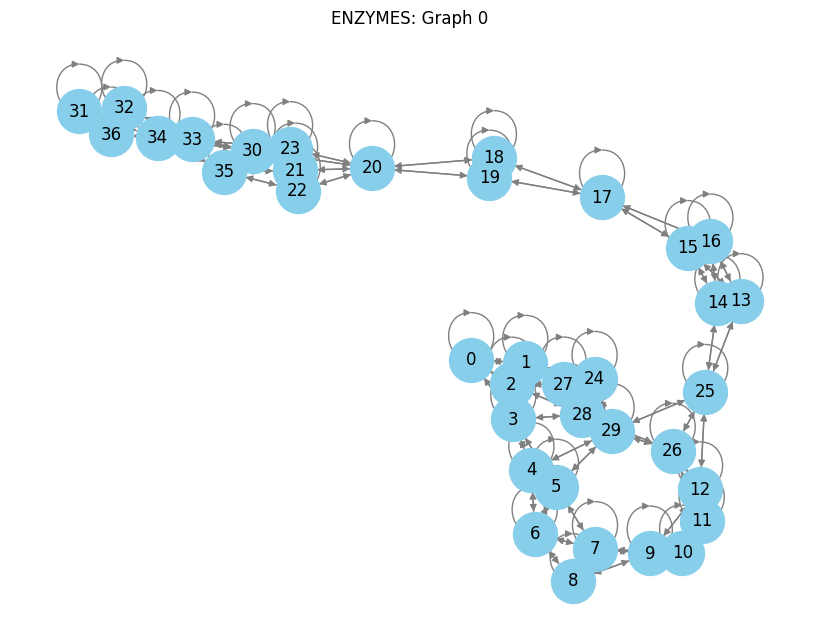

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(nx_graph, title=None):
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(nx_graph, seed=42)
    nx.draw(nx_graph, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=1000)
    if title:
        plt.title(title)
    plt.show()

# Visualize the first graph from the ENZYMES dataset
visualize_graph(enzymes_nx_graphs[0], title='ENZYMES: Graph 0')

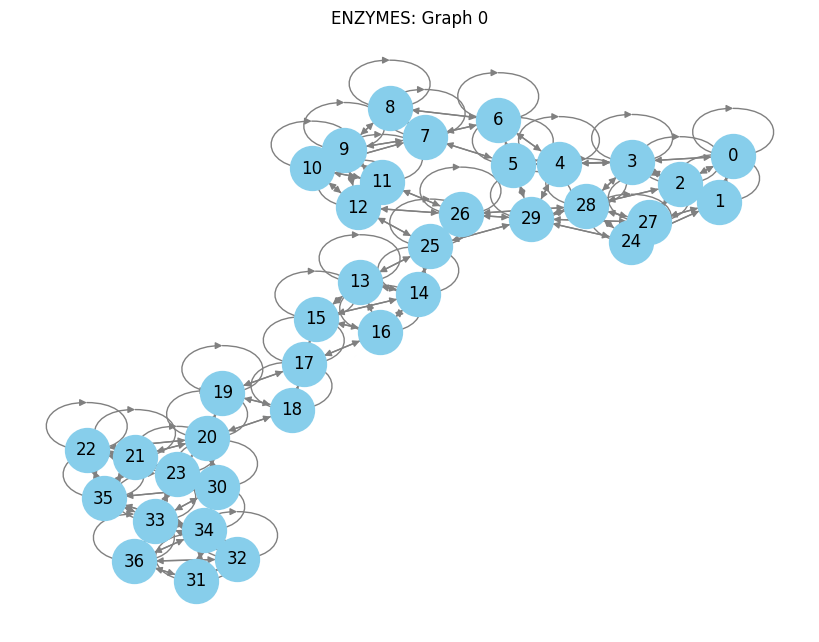

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(nx_graph, title=None):
    plt.figure(figsize=(8, 6))
    pos = nx.kamada_kawai_layout(nx_graph)
    nx.draw(nx_graph, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=1000)
    if title:
        plt.title(title)
    plt.show()

# Visualize the first graph from the ENZYMES dataset
visualize_graph(enzymes_nx_graphs[0], title='ENZYMES: Graph 0')

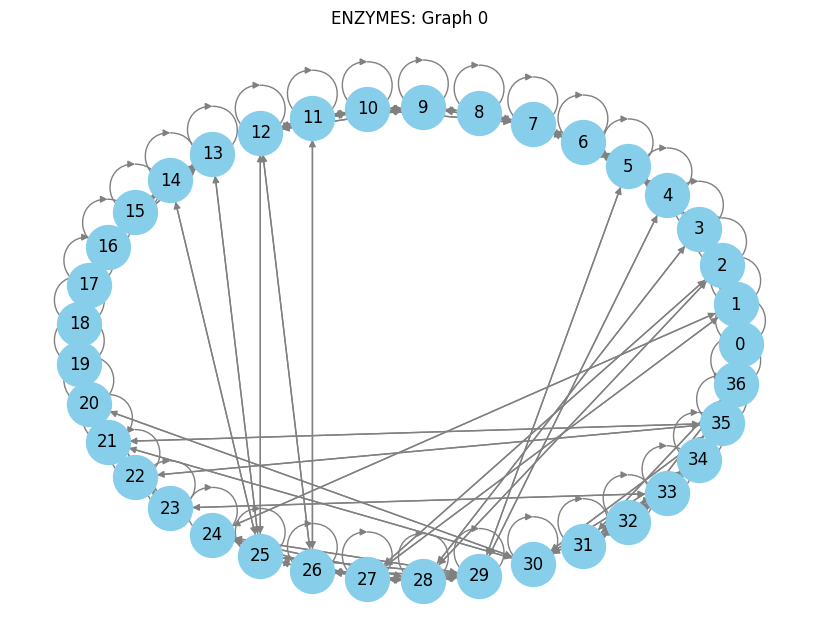

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(nx_graph, title=None):
    plt.figure(figsize=(8, 6))
    pos = nx.circular_layout(nx_graph)
    nx.draw(nx_graph, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=1000)
    if title:
        plt.title(title)
    plt.show()

# Visualize the first graph from the ENZYMES dataset
visualize_graph(enzymes_nx_graphs[0], title='ENZYMES: Graph 0')

<ipython-input-39-16497d414ada>:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


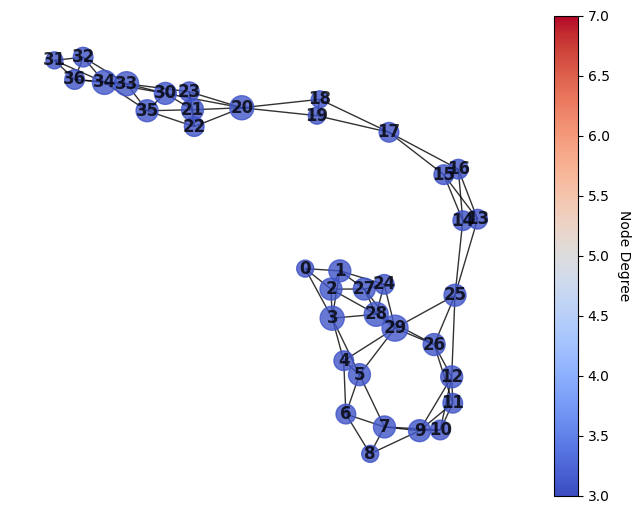

In [ ]:
import dgl
import networkx as nx
import matplotlib.pyplot as plt

# Load the enzymes dataset
dataset = dgl.data.TUDataset(name='ENZYMES')

# Select a graph from the dataset
graph, _ = dataset[0]

# Convert the DGL graph to a networkx graph
nx_g = dgl.to_networkx(graph).to_undirected()

# Set the node positions using the spring layout algorithm
pos = nx.spring_layout(nx_g, seed=42)

# Calculate node degrees
degrees = nx.degree(nx_g)

# Customize node colors and sizes based on their degrees
degree_list = [degree for _, degree in degrees]
node_colors = plt.cm.coolwarm(degree_list)
node_sizes = [degree * 50 for degree in degree_list]

# Draw the graph
nx.draw(nx_g, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, alpha=0.8, font_weight='bold')

# Add a colorbar to represent the node degrees
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min(degree_list), vmax=max(degree_list)))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Node Degree', rotation=270, labelpad=15)

# Save the figure in a high-quality format
plt.savefig("graph_visualization.svg", format="svg")
plt.show()


<ipython-input-42-6d39eb4a3e1d>:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


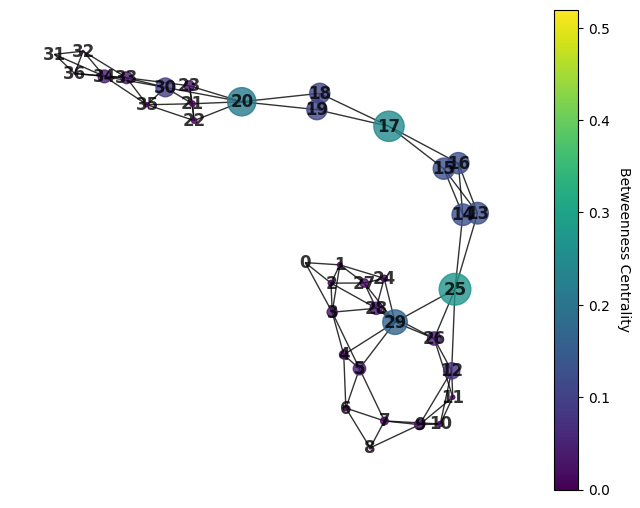

In [ ]:
## Betweenness centrality
import dgl
import networkx as nx
import matplotlib.pyplot as plt

dataset = dgl.data.TUDataset(name='ENZYMES')

graph, _ = dataset[0]

nx_g = dgl.to_networkx(graph).to_undirected()

pos = nx.spring_layout(nx_g, seed=42)

betweenness_centrality = nx.betweenness_centrality(nx_g)

betweenness_values = list(betweenness_centrality.values())
node_colors = plt.cm.viridis(betweenness_values)
node_sizes = [between * 1000 for between in betweenness_values]

nx.draw(nx_g, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, alpha=0.8, font_weight='bold')

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(betweenness_values), vmax=max(betweenness_values)))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Betweenness Centrality', rotation=270, labelpad=15)

plt.savefig("graph_visualization_betweenness.svg", format="svg")
plt.show()


In [ ]:
graph, _ = dataset_enzymes[0]  # Get the first graph from the dataset
node_attributes = graph.ndata['node_attr']  # Access the node attributes

print("Node attributes shape:", node_attributes.shape)

Node attributes shape: torch.Size([37, 18])
